In [1]:
import sys
sys.path.insert(0, '/home/aymane/School/pothole-localization/src/data')
sys.path.insert(1, '/home/aymane/School/pothole-localization/src/helper')

print(sys.path)

['/home/aymane/School/pothole-localization/src/data', '/home/aymane/School/pothole-localization/src/helper', '/home/aymane/School/pothole-localization/notebooks', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/aymane/School/pothole-localization/venv/lib/python3.10/site-packages', '/home/aymane/.local/lib/python3.10/site-packages', '/usr/lib/python3.10/site-packages']


In [2]:
#TODO add all modules to path using a function
import torch
import torch.utils.data 
import numpy as np
import matplotlib.pyplot as plt
from display_image import display_image

from torch.utils.data import DataLoader
from segmentation_dataset import SegmentationDataset

raw_data_path   = '/home/aymane/School/pothole-localization/data/segmentation/raw'
data_path       = '/home/aymane/School/pothole-localization/data/segmentation/augment_11/data.pt'
label_path      = '/home/aymane/School/pothole-localization/data/segmentation/augment_11/label.pt'

# dataset = SegmentationDataset(raw_data_path=raw_data_path)
dataset = SegmentationDataset(data_path=data_path, label_path=label_path)

split = [int(len(dataset) * i) for i in [0.8, 0.1, 0.1]]

train, test, valid = torch.utils.data.random_split(dataset, split)

train_data  = DataLoader(dataset=train, batch_size=8, shuffle=True, num_workers=8)
test_data   = DataLoader(dataset=test, batch_size=8, shuffle=False, num_workers=8)
valid_data  = DataLoader(dataset=valid, batch_size=8, shuffle=False, num_workers=8)

del train, test, valid

In [3]:
# # import required libraries
# import torch
# from torchvision import transforms
# from PIL import Image
# import matplotlib.pyplot as plt
# from display_image import display_image as di


# # define a torch tensor
# i = 174

# tensor1 = train[i][0]
# tensor2 = train[i][1]

# di(tensor1)
# di(tensor2)

In [4]:
import segmentation_models_pytorch as smp
from segmentation_model import SegmentationModel
import pytorch_lightning as pl

model = SegmentationModel("FPN", "resnet34", in_channels=3, out_classes=1)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1, 
    max_epochs=5,
)

trainer.fit(
    model, 
    train_dataloaders=train_data, 
    val_dataloaders=valid_data,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [7]:
test_metrics = trainer.test(model, dataloaders=test_data, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_per_image_iou': 0.8449821472167969, 'test_dataset_iou': 0.8616792559623718}]


In [17]:
from display_image import display_image
from torchvision import transforms


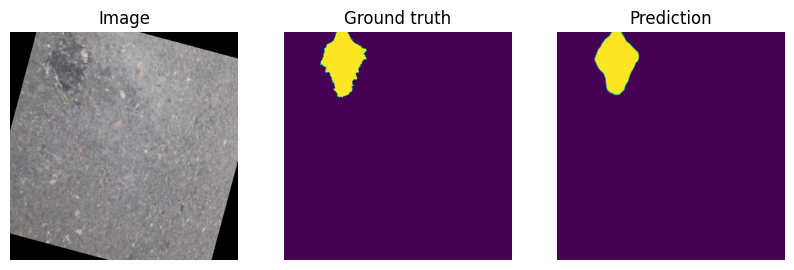

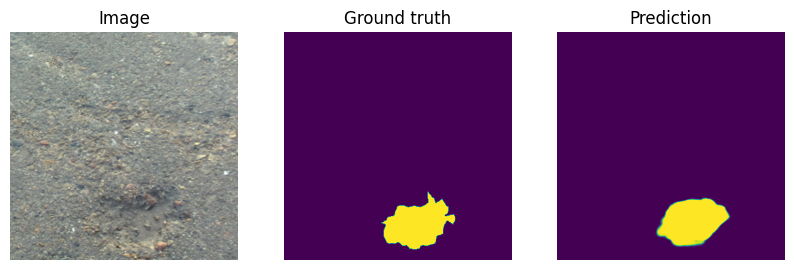

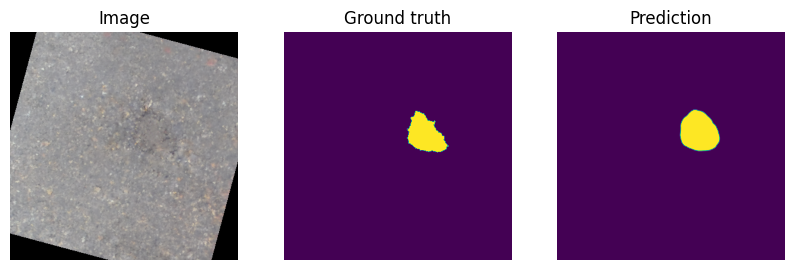

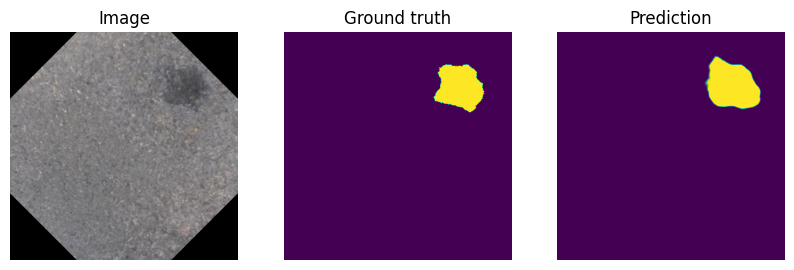

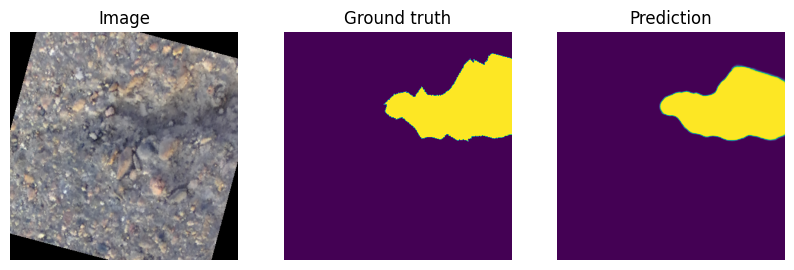

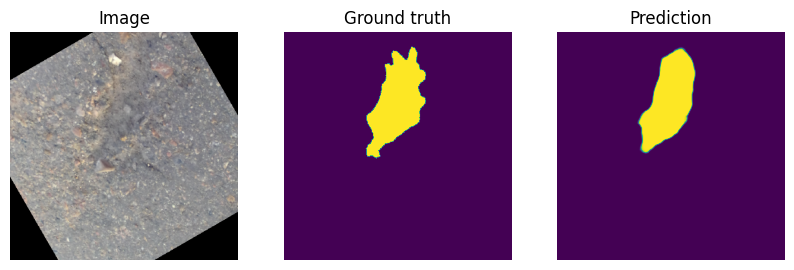

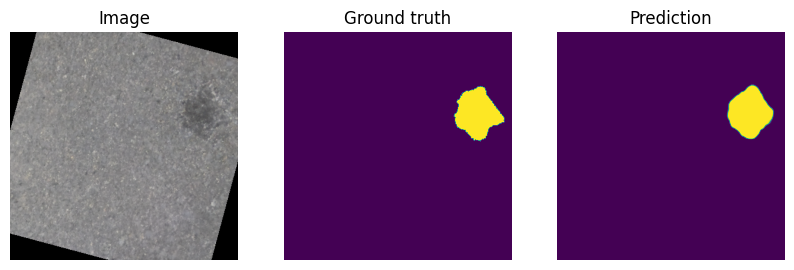

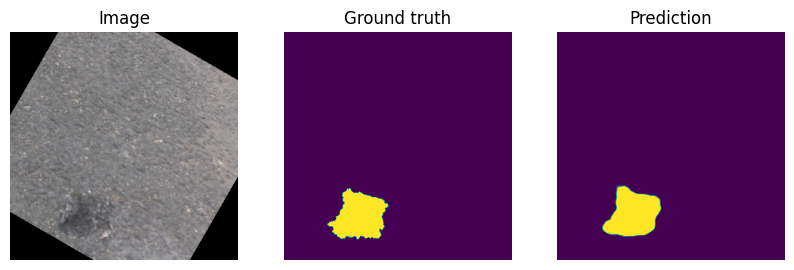

In [19]:
batch = next(iter(test_data))
with torch.no_grad():
    model.eval()
    logits = model(batch[0])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(transforms.ToPILImage()(image/255)) 
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()